RECURRENT NEURAL NETWORK

Epoch 1/50, Train Loss: 0.2821
Epoch 2/50, Train Loss: 0.0230
Epoch 3/50, Train Loss: 0.0011
Epoch 4/50, Train Loss: 0.0002
Epoch 5/50, Train Loss: 0.0001
Epoch 6/50, Train Loss: 0.0001
Epoch 7/50, Train Loss: 0.0001
Epoch 8/50, Train Loss: 0.0001
Epoch 9/50, Train Loss: 0.0001
Epoch 10/50, Train Loss: 0.0001
Epoch 11/50, Train Loss: 0.0001
Epoch 12/50, Train Loss: 0.0001
Epoch 13/50, Train Loss: 0.0000
Epoch 14/50, Train Loss: 0.0000
Epoch 15/50, Train Loss: 0.0000
Epoch 16/50, Train Loss: 0.0000
Epoch 17/50, Train Loss: 0.0000
Epoch 18/50, Train Loss: 0.0000
Epoch 19/50, Train Loss: 0.0000
Epoch 20/50, Train Loss: 0.0000
Epoch 21/50, Train Loss: 0.0000
Epoch 22/50, Train Loss: 0.0000
Epoch 23/50, Train Loss: 0.0000
Epoch 24/50, Train Loss: 0.0000
Epoch 25/50, Train Loss: 0.0000
Epoch 26/50, Train Loss: 0.0000
Epoch 27/50, Train Loss: 0.0000
Epoch 28/50, Train Loss: 0.0000
Epoch 29/50, Train Loss: 0.0000
Epoch 30/50, Train Loss: 0.0000
Epoch 31/50, Train Loss: 0.0000
Epoch 32/50, Trai

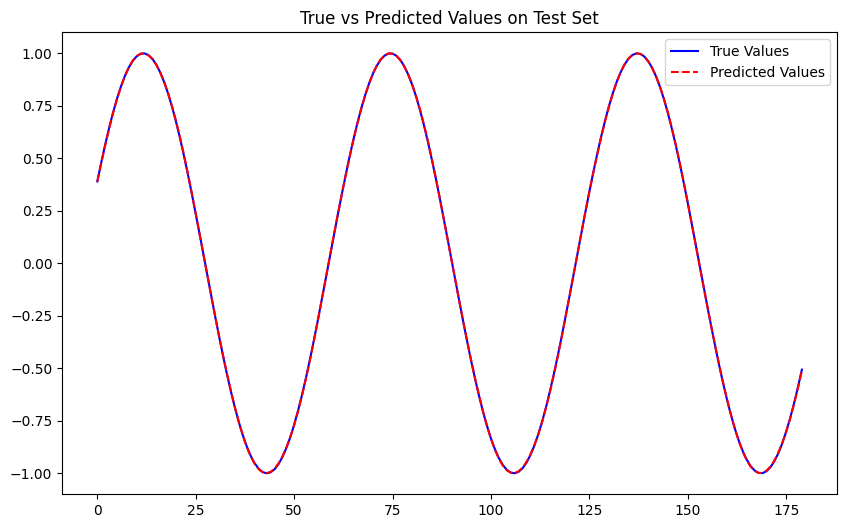

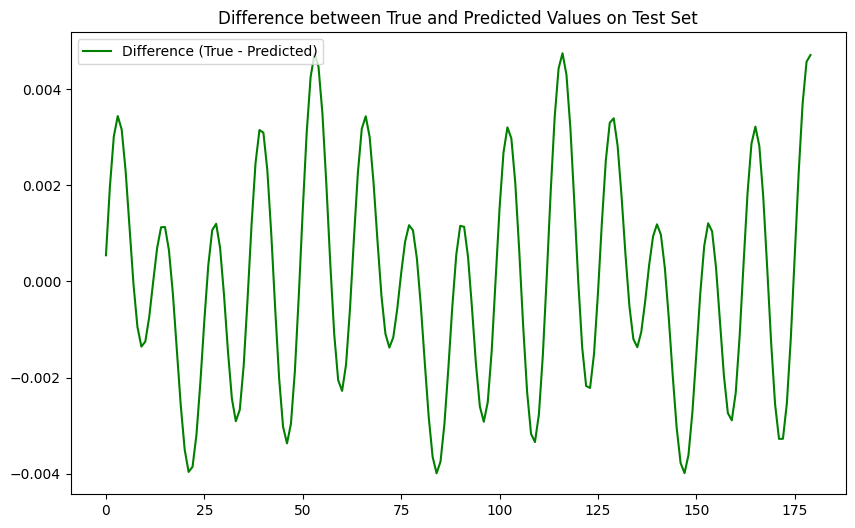

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

# Create synthetic time series (sine wave)
time_steps = 1000
t = np.linspace(0, 100, time_steps)
data = np.sin(t)

# Normalize the data (between 0 and 1)
scaler = MinMaxScaler(feature_range=(-1, 1))
data_scaled = scaler.fit_transform(data.reshape(-1, 1))

# Convert to PyTorch tensors
data_scaled = torch.FloatTensor(data_scaled).view(-1)

# Split data into training and test sets
train_size = int(len(data_scaled) * 0.8)
train_data, test_data = data_scaled[:train_size], data_scaled[train_size:]

# Create Dataset class for Time Series Data
class TimeSeriesDataset(torch.utils.data.Dataset):
    def __init__(self, data, seq_length=10):
        self.data = data
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, idx):
        x = self.data[idx:idx + self.seq_length]
        y = self.data[idx + self.seq_length]
        return x, y

# Create datasets and DataLoader
seq_length = 20  # Sequence length
train_dataset = TimeSeriesDataset(train_data, seq_length)
test_dataset = TimeSeriesDataset(test_data, seq_length)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define the RNN Model
class RNNModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, output_size=1, num_layers=1):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)  # Output from RNN (batch_size, seq_length, hidden_size)
        out = self.fc(out[:, -1, :])  # We only care about the last time step
        return out

# Initialize the model, loss function, and optimizer
model = RNNModel(input_size=1, hidden_size=64, output_size=1, num_layers=1)
criterion = nn.MSELoss()  # Mean Squared Error loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
epochs = 50
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.unsqueeze(-1)
        y_batch = y_batch.unsqueeze(-1)

        optimizer.zero_grad()
        y_pred = model(x_batch)
        loss = criterion(y_pred, y_batch)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}")

# Evaluate the model on the test set
model.eval()  # Set the model to evaluation mode
test_preds = []
test_true = []

with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.unsqueeze(-1)
        y_batch = y_batch.unsqueeze(-1)

        y_pred = model(x_batch)
        test_preds.append(y_pred.numpy())
        test_true.append(y_batch.numpy())

# Convert lists to numpy arrays
test_preds = np.concatenate(test_preds, axis=0)
test_true = np.concatenate(test_true, axis=0)

# Inverse transform the data to get the original scale
test_preds = scaler.inverse_transform(test_preds)
test_true = scaler.inverse_transform(test_true)

# Flatten the arrays if they have an extra dimension
test_preds = test_preds.flatten()
test_true = test_true.flatten()

# Calculate MAE (Mean Absolute Error)
mae = mean_absolute_error(test_true, test_preds)
print(f"Mean Absolute Error (MAE) on Test Set: {mae:.4f}")

# Calculate accuracy as percentage of predictions within 5% of the true value
def calculate_accuracy(y_true, y_pred, tolerance=0.05):
    # Calculate absolute percentage error
    abs_percentage_error = np.abs((y_true - y_pred) / y_true)

    # Count how many predictions are within the tolerance range
    accuracy = np.sum(abs_percentage_error <= tolerance) / len(y_true) * 100
    return accuracy

accuracy = calculate_accuracy(test_true, test_preds, tolerance=0.05)
print(f"Accuracy (within 5% tolerance) on Test Set: {accuracy:.2f}%")

# Plot the results with different line styles
plt.figure(figsize=(10, 6))
plt.plot(test_true, label='True Values', color='blue', linestyle='-')  # Solid line for true values
plt.plot(test_preds, label='Predicted Values', color='red', linestyle='--')  # Dashed line for predicted values
plt.legend()
plt.title("True vs Predicted Values on Test Set")
plt.show()

# Alternatively, plot the difference between true and predicted values
plt.figure(figsize=(10, 6))
plt.plot(test_true - test_preds, label='Difference (True - Predicted)', color='green')
plt.legend()
plt.title("Difference between True and Predicted Values on Test Set")
plt.show()
